In [1]:
%run multilabel_preprocessing.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def compute_weights_multilabel(y, num_classes=10):
    # Ensure y is a 2D array
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    # Count occurrences of each class
    class_counts = np.sum(y, axis=0)
    
    # Compute weights
    weights = np.zeros(num_classes)
    n_samples = len(y)
    
    for i in range(num_classes):
        if class_counts[i] > 0:
            weights[i] = (n_samples / (num_classes * class_counts[i]))
        else:
            weights[i] = 1.0  # or any other strategy for classes with no samples
    
    # Normalize weights
    weights = weights / np.sum(weights) * num_classes
    
    # Create a dictionary mapping class labels to weights
    class_weight_dict = {i: weight for i, weight in enumerate(weights)}
    
    class_weights = torch.FloatTensor(list(class_weight_dict.values())).cuda()

    return class_weights

In [6]:
class_weights = compute_weights_multilabel(y_train)

In [7]:
# class_weights = [  1.27662835,   2.41449275,  17.53684211,  12.81538462,
#          7.40444444, 111.06666667,  23.8       ,  13.328     ,
#          0.13489879,   1.00664653]
# class_weights = torch.tensor(class_weights).to(device)

In [8]:
num_classes = y_train.shape[1]
num_classes

10

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, dropout=dropout_prob, bidirectional=False)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.leaky_relu1 = nn.LeakyReLU(0.02)
        
        # self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True, dropout=dropout_prob, bidirectional=False)
        # self.bn2 = nn.BatchNorm1d(hidden_dim)
        # self.leaky_relu2 = nn.LeakyReLU(slope)
        
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True, dropout=dropout_prob, bidirectional=False)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.leaky_relu3 = nn.LeakyReLU(0.02)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.bn1(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.leaky_relu1(out)
        
        # out, _ = self.lstm2(out)
        # out = self.bn2(out.permute(0, 2, 1)).permute(0, 2, 1)
        # out = self.leaky_relu2(out)
        
        out, _ = self.lstm3(out)
        out = self.bn3(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.leaky_relu3(out)
        
        out = out[:, -1, :] 
        out = self.fc(out)
        
        return out


In [10]:
input_dim = X_train.shape[2]
hidden_dim=64
output_dim = num_classes
dropout_prob = 0.3

model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_prob).to(device)

In [11]:
model

LSTMModel(
  (lstm1): LSTM(1, 64, batch_first=True, dropout=0.3)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.02)
  (lstm3): LSTM(64, 64, batch_first=True, dropout=0.3)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.02)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

In [13]:
train_losses = []
test_losses = []
accuracy_values = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_total = 0
    correct = 0
    test_total = 0
    test_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_total += labels.size(0)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            correct += (predicted == labels).sum().item()
            test_total += labels.numel()

    train_loss = running_loss / train_total
    test_loss = test_loss / test_total
    accuracy = correct / test_total
    
    # Store losses for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracy_values.append(accuracy*100)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy*100:.4f}%')

Epoch 1/30, Train Loss: 0.4936, Test Loss: 0.0400, Accuracy: 85.0282%
Epoch 2/30, Train Loss: 0.3046, Test Loss: 0.0271, Accuracy: 86.2712%
Epoch 3/30, Train Loss: 0.1960, Test Loss: 0.0193, Accuracy: 86.1017%
Epoch 4/30, Train Loss: 0.1437, Test Loss: 0.0145, Accuracy: 86.1723%
Epoch 5/30, Train Loss: 0.1162, Test Loss: 0.0116, Accuracy: 86.1864%
Epoch 6/30, Train Loss: 0.1000, Test Loss: 0.0098, Accuracy: 86.1864%
Epoch 7/30, Train Loss: 0.0893, Test Loss: 0.0087, Accuracy: 86.2288%
Epoch 8/30, Train Loss: 0.0828, Test Loss: 0.0080, Accuracy: 86.2429%
Epoch 9/30, Train Loss: 0.0784, Test Loss: 0.0075, Accuracy: 86.2571%
Epoch 10/30, Train Loss: 0.0754, Test Loss: 0.0072, Accuracy: 86.2571%
Epoch 11/30, Train Loss: 0.0731, Test Loss: 0.0069, Accuracy: 86.2571%
Epoch 12/30, Train Loss: 0.0714, Test Loss: 0.0067, Accuracy: 86.2712%
Epoch 13/30, Train Loss: 0.0700, Test Loss: 0.0066, Accuracy: 86.2712%
Epoch 14/30, Train Loss: 0.0687, Test Loss: 0.0065, Accuracy: 86.2712%
Epoch 15/30, Tr

In [14]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        correct += (predicted == labels).sum().item()
        test_total += labels.numel()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    
accuracy = correct / test_total
print(f'Accuracy: {accuracy}')

Accuracy: 0.8677966101694915


In [15]:
precision = precision_score(y_true, y_pred, average='samples')
recall = recall_score(y_true, y_pred, average='samples')
f1 = f1_score(y_true, y_pred, average='samples')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

Precision: 0.0494, Recall: 0.0247, F1-score: 0.0330


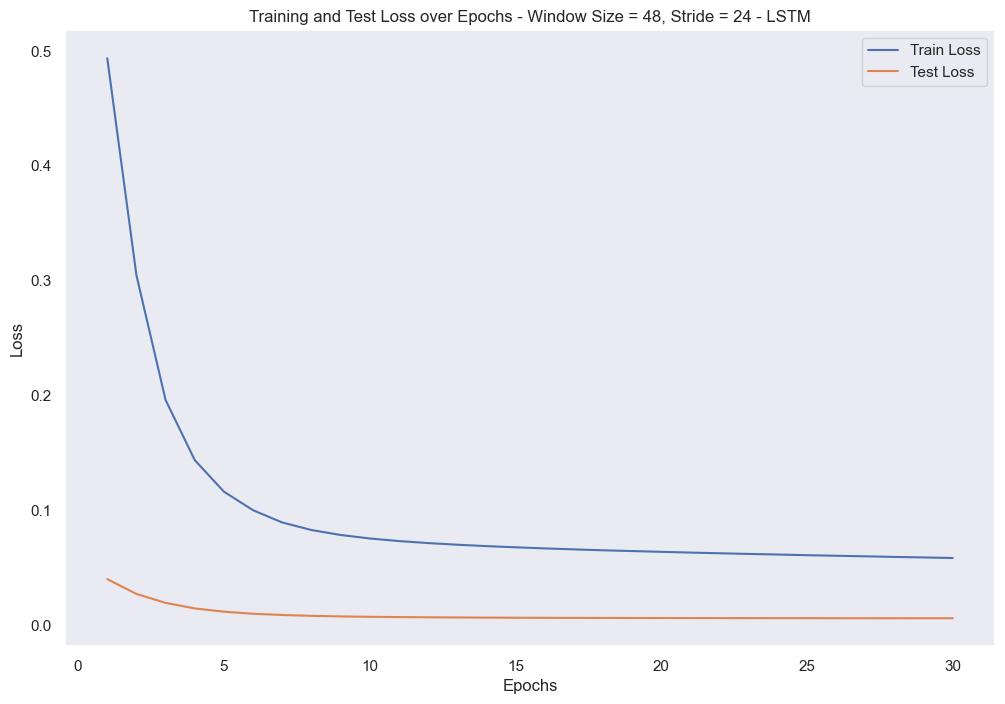

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Test Loss over Epochs - Window Size = {window_size}, Stride = {stride} - LSTM')
plt.legend()
plt.grid(False)
plt.show()

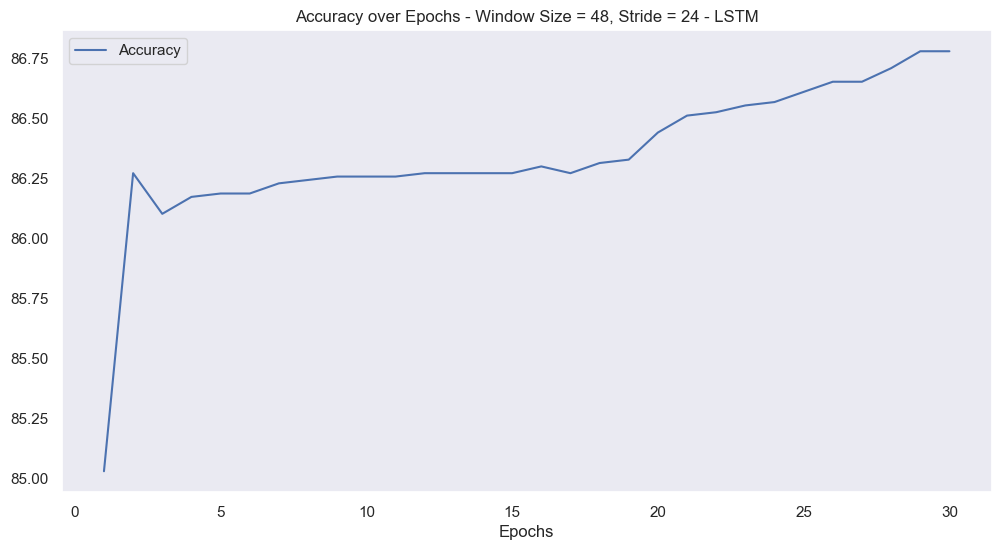

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), accuracy_values, label='Accuracy')
plt.xlabel('Epochs')
plt.title(f'Accuracy over Epochs - Window Size = {window_size}, Stride = {stride} - LSTM')
plt.legend()
plt.grid(False)
plt.show()

In [18]:
mcm = multilabel_confusion_matrix(y_true, y_pred)

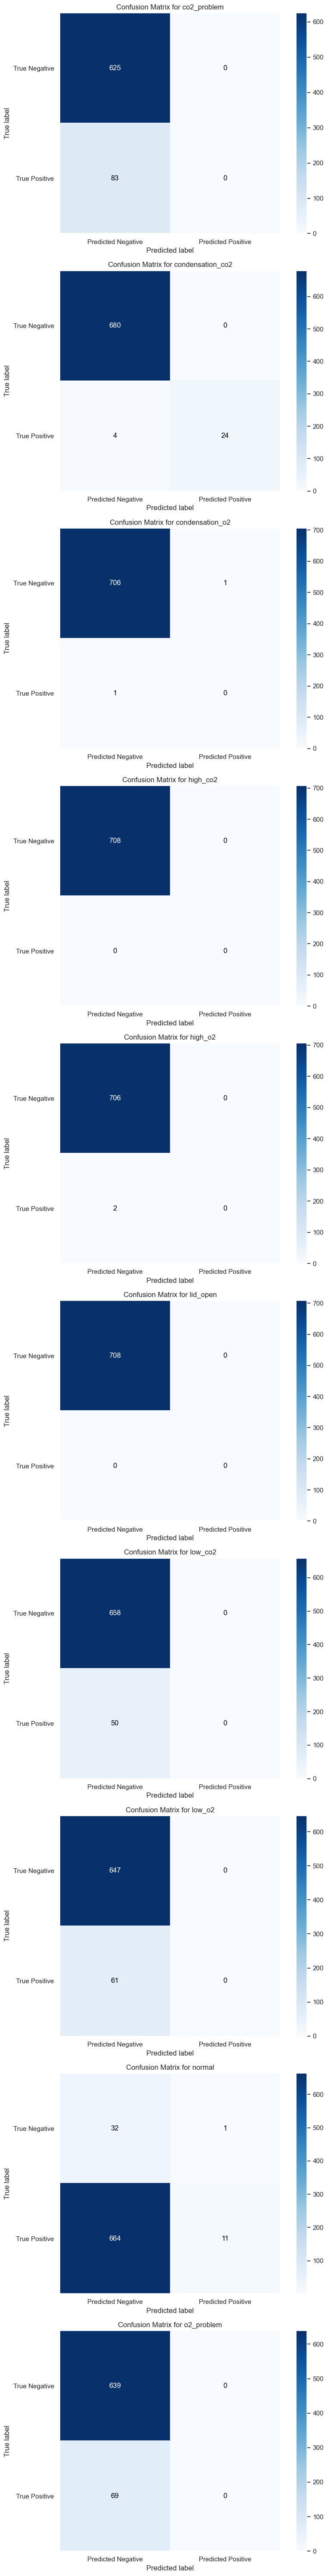

In [19]:
def plot_multilabel_confusion_matrix(mcm, class_names):
    n_classes = mcm.shape[0]
    fig, axes = plt.subplots(n_classes, 1, figsize=(8, 6 * n_classes))
    
    for i, (cm, class_name) in enumerate(zip(mcm, class_names)):
        ax = axes[i] if n_classes > 1 else axes
        
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=['Predicted Negative', 'Predicted Positive'],
               yticklabels=['True Negative', 'True Positive'],
               title=f'Confusion Matrix for {class_name}',
               ylabel='True label',
               xlabel='Predicted label')
        
        # Rotate the tick labels and set their alignment.
        # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
                ax.grid(False)
    
    plt.tight_layout()
    plt.show()

class_names = labels_df.columns
plot_multilabel_confusion_matrix(mcm, class_names)
